In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import rdkit
from rdkit import Chem

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')  

# Helper functions

In [2]:
def convert_df_smis_to_fps(df, smi_column = 'SMILES'):
    smiles = list(df[smi_column])
    mols = [Chem.MolFromSmiles(x) for x in smiles if type(x) is not float]
    fps = [Chem.RDKFingerprint(x) for x in mols if x is not None]
    return(fps)

def make_joined_list_of_fps_and_labels(list_of_lists, labels_in_order):
    fp_list = []
    lab_list = []
    for lab, currlist in zip(labels_in_order, list_of_lists):
        fp_list.extend(currlist) # could be slow for long lists or many long lists
        lab_list.extend([lab] * len(currlist))
    return(fp_list, lab_list)

def tsne_from_pca_components(fp_list, fp_labels, fig_path, colors = None):
    # use all PCs
    pca = PCA(n_components=np.min([len(fp_list), len(fp_list[0])]))
    crds = pca.fit_transform(fp_list)

    # use PCs as input to tSNE
    crds_embedded = TSNE(n_components=2).fit_transform(crds)

    tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
    tsne_df['label'] = fp_labels
              
    plt.figure(figsize=(8,5), dpi = 300)
    if colors == None:
        palette = sns.color_palette("hls", len(set(fp_labels)))
    else:
        ordered_labs = tsne_df.drop_duplicates('label')
        palette = dict(zip(list(ordered_labs['label']), colors))
    ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="label", palette = palette, alpha = 0.7, s = 7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(fig_path + '.png')
    plt.savefig(fig_path + '.svg')  
    plt.show()

# Plot 37K, abx, PK-1760 t-SNE

In [3]:
data_path = '../data/'

full37kpk = pd.read_csv(data_path + 'data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv')
print('num 37K + PK: ', len(full37kpk))

pkonly = pd.read_csv(data_path + 'data_prep_for_ml/data_prep_for_ml_pk_screen/FULL_11_15_2021.csv')
print('num PK only: ', len(pkonly))

full37konly = full37kpk[[smi not in list(pkonly['SMILES']) for smi in list(full37kpk['SMILES'])]]
print('num 37K only: ', len(full37konly))

abx = pd.read_csv(data_path + '04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
print('num abx: ', len(abx))

num 37K + PK:  38680
num PK only:  1759
num 37K only:  36897
num abx:  566


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


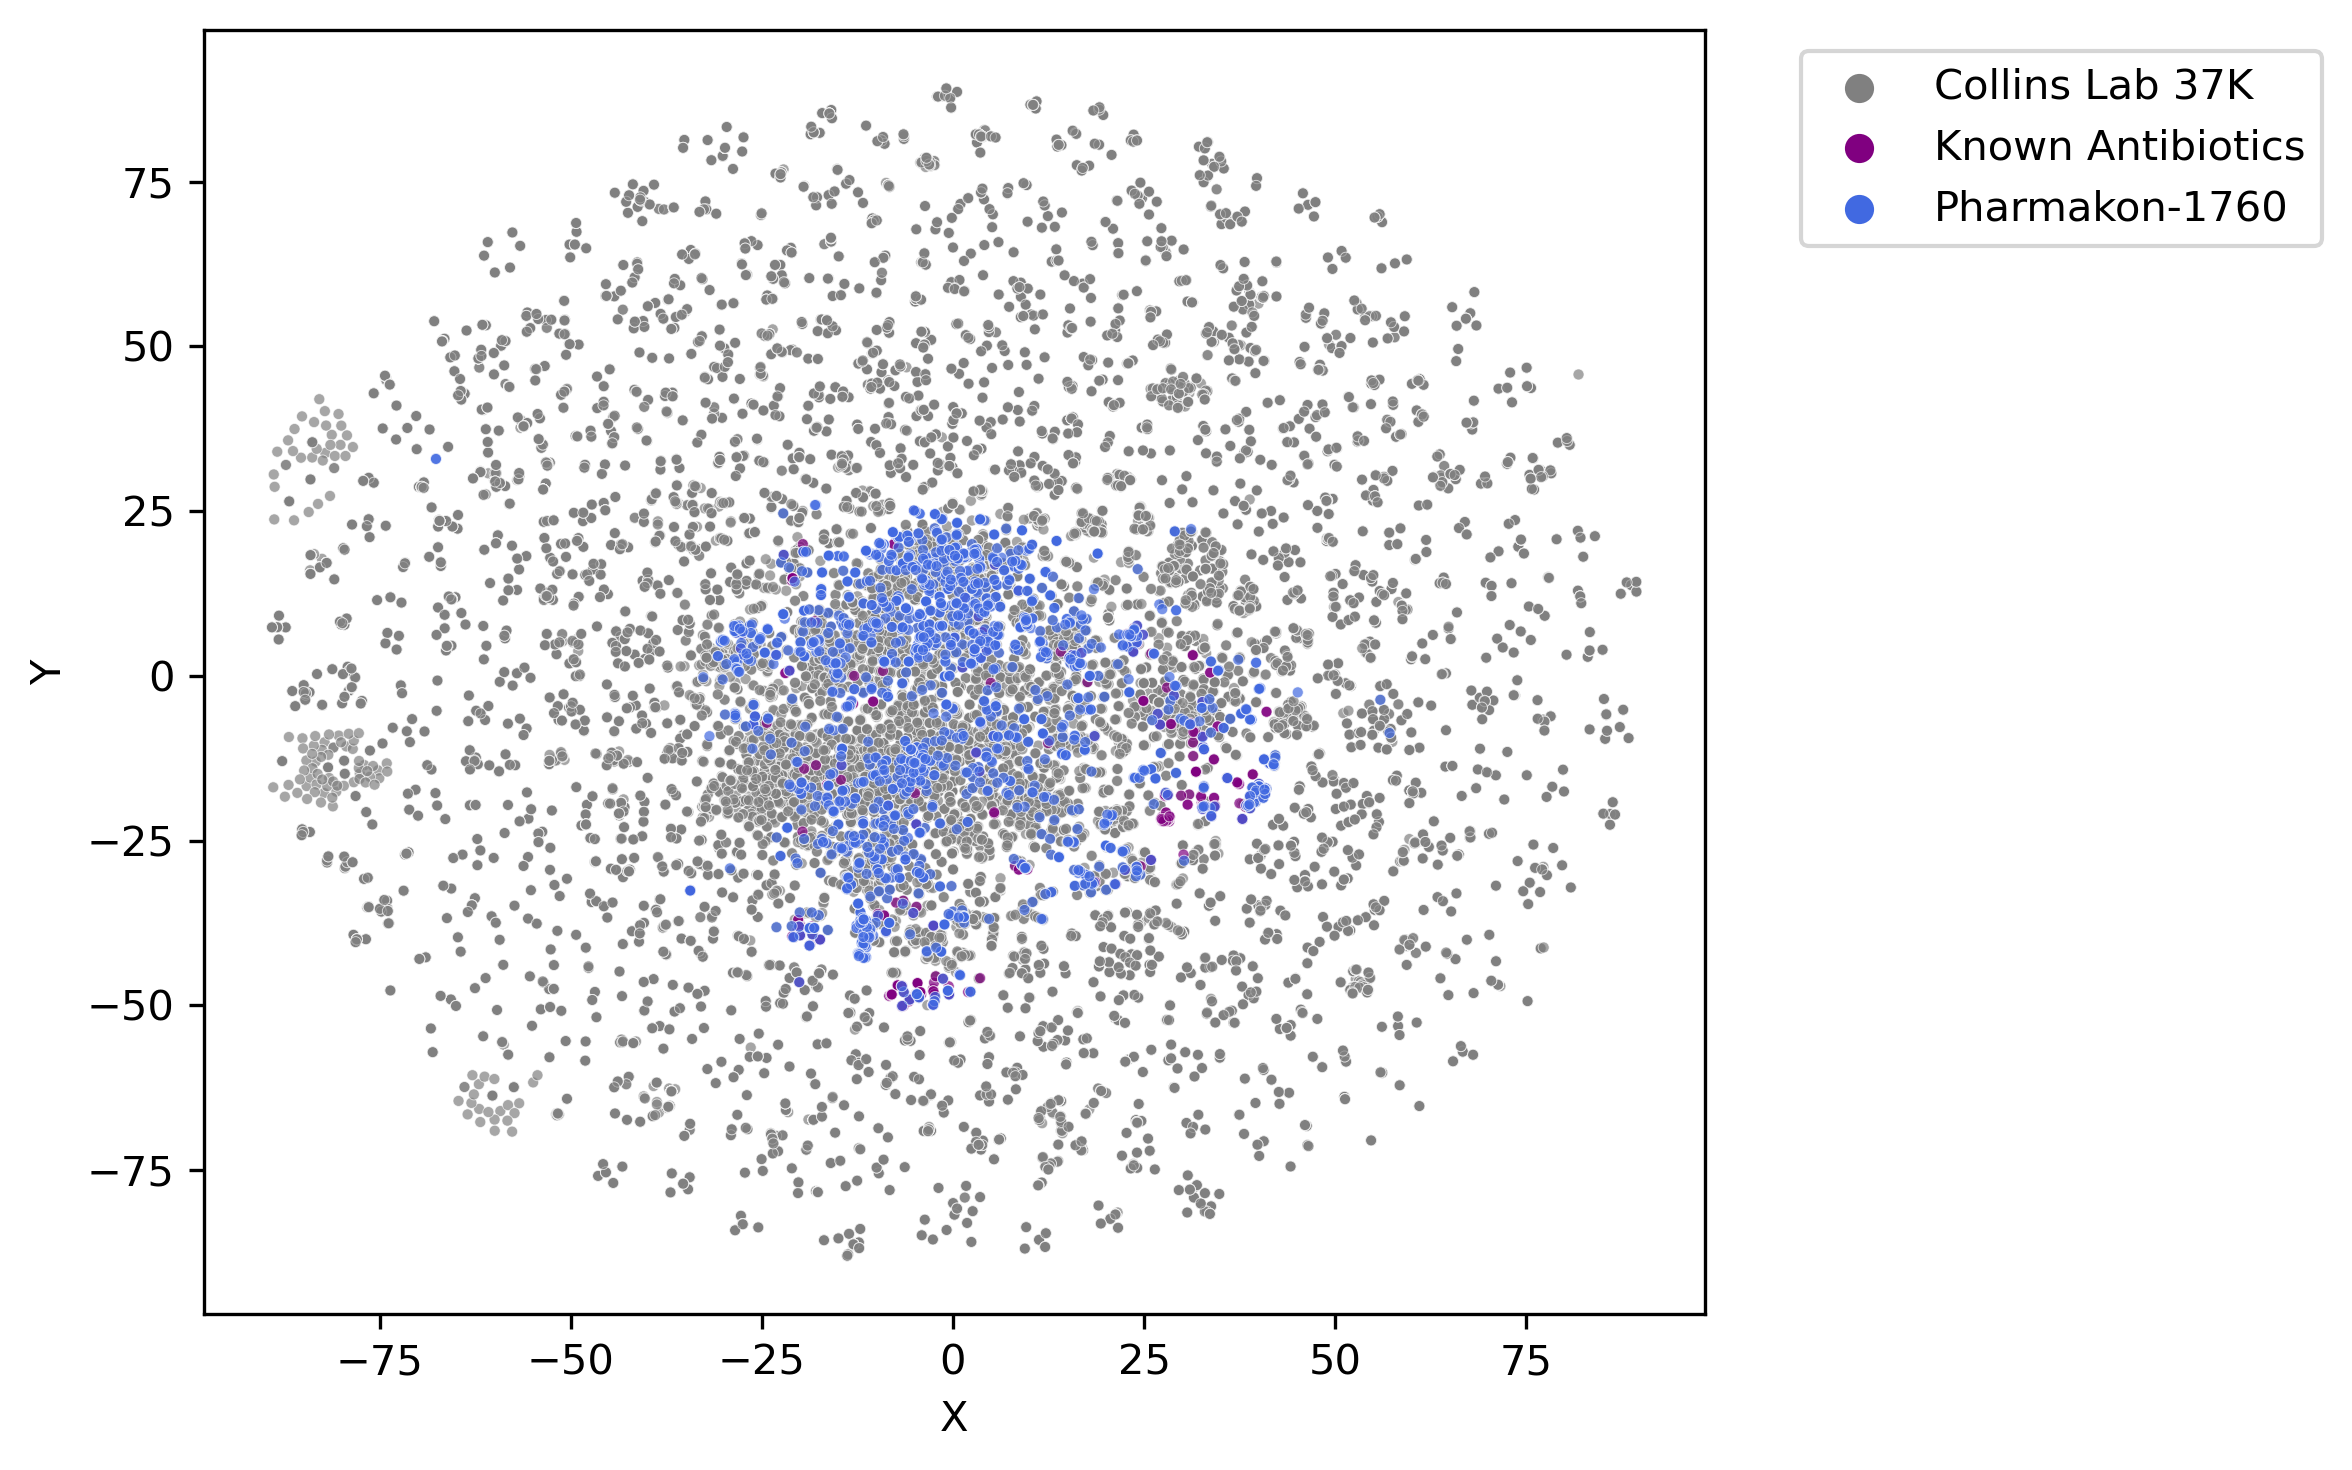

In [18]:
fp_37k = convert_df_smis_to_fps(full37konly, 'SMILES')
fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
fp_pk = convert_df_smis_to_fps(pkonly, 'SMILES')

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37k, fp_abx, fp_pk], 
                                                       ['Collins Lab 37K', 'Known Antibiotics', 'Pharmakon-1760'])

tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_37k_PK_abx', colors = ['grey', 'purple', 'royalblue'])

# Plot 37K+PK hits and non-hits, abx t-SNE

/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


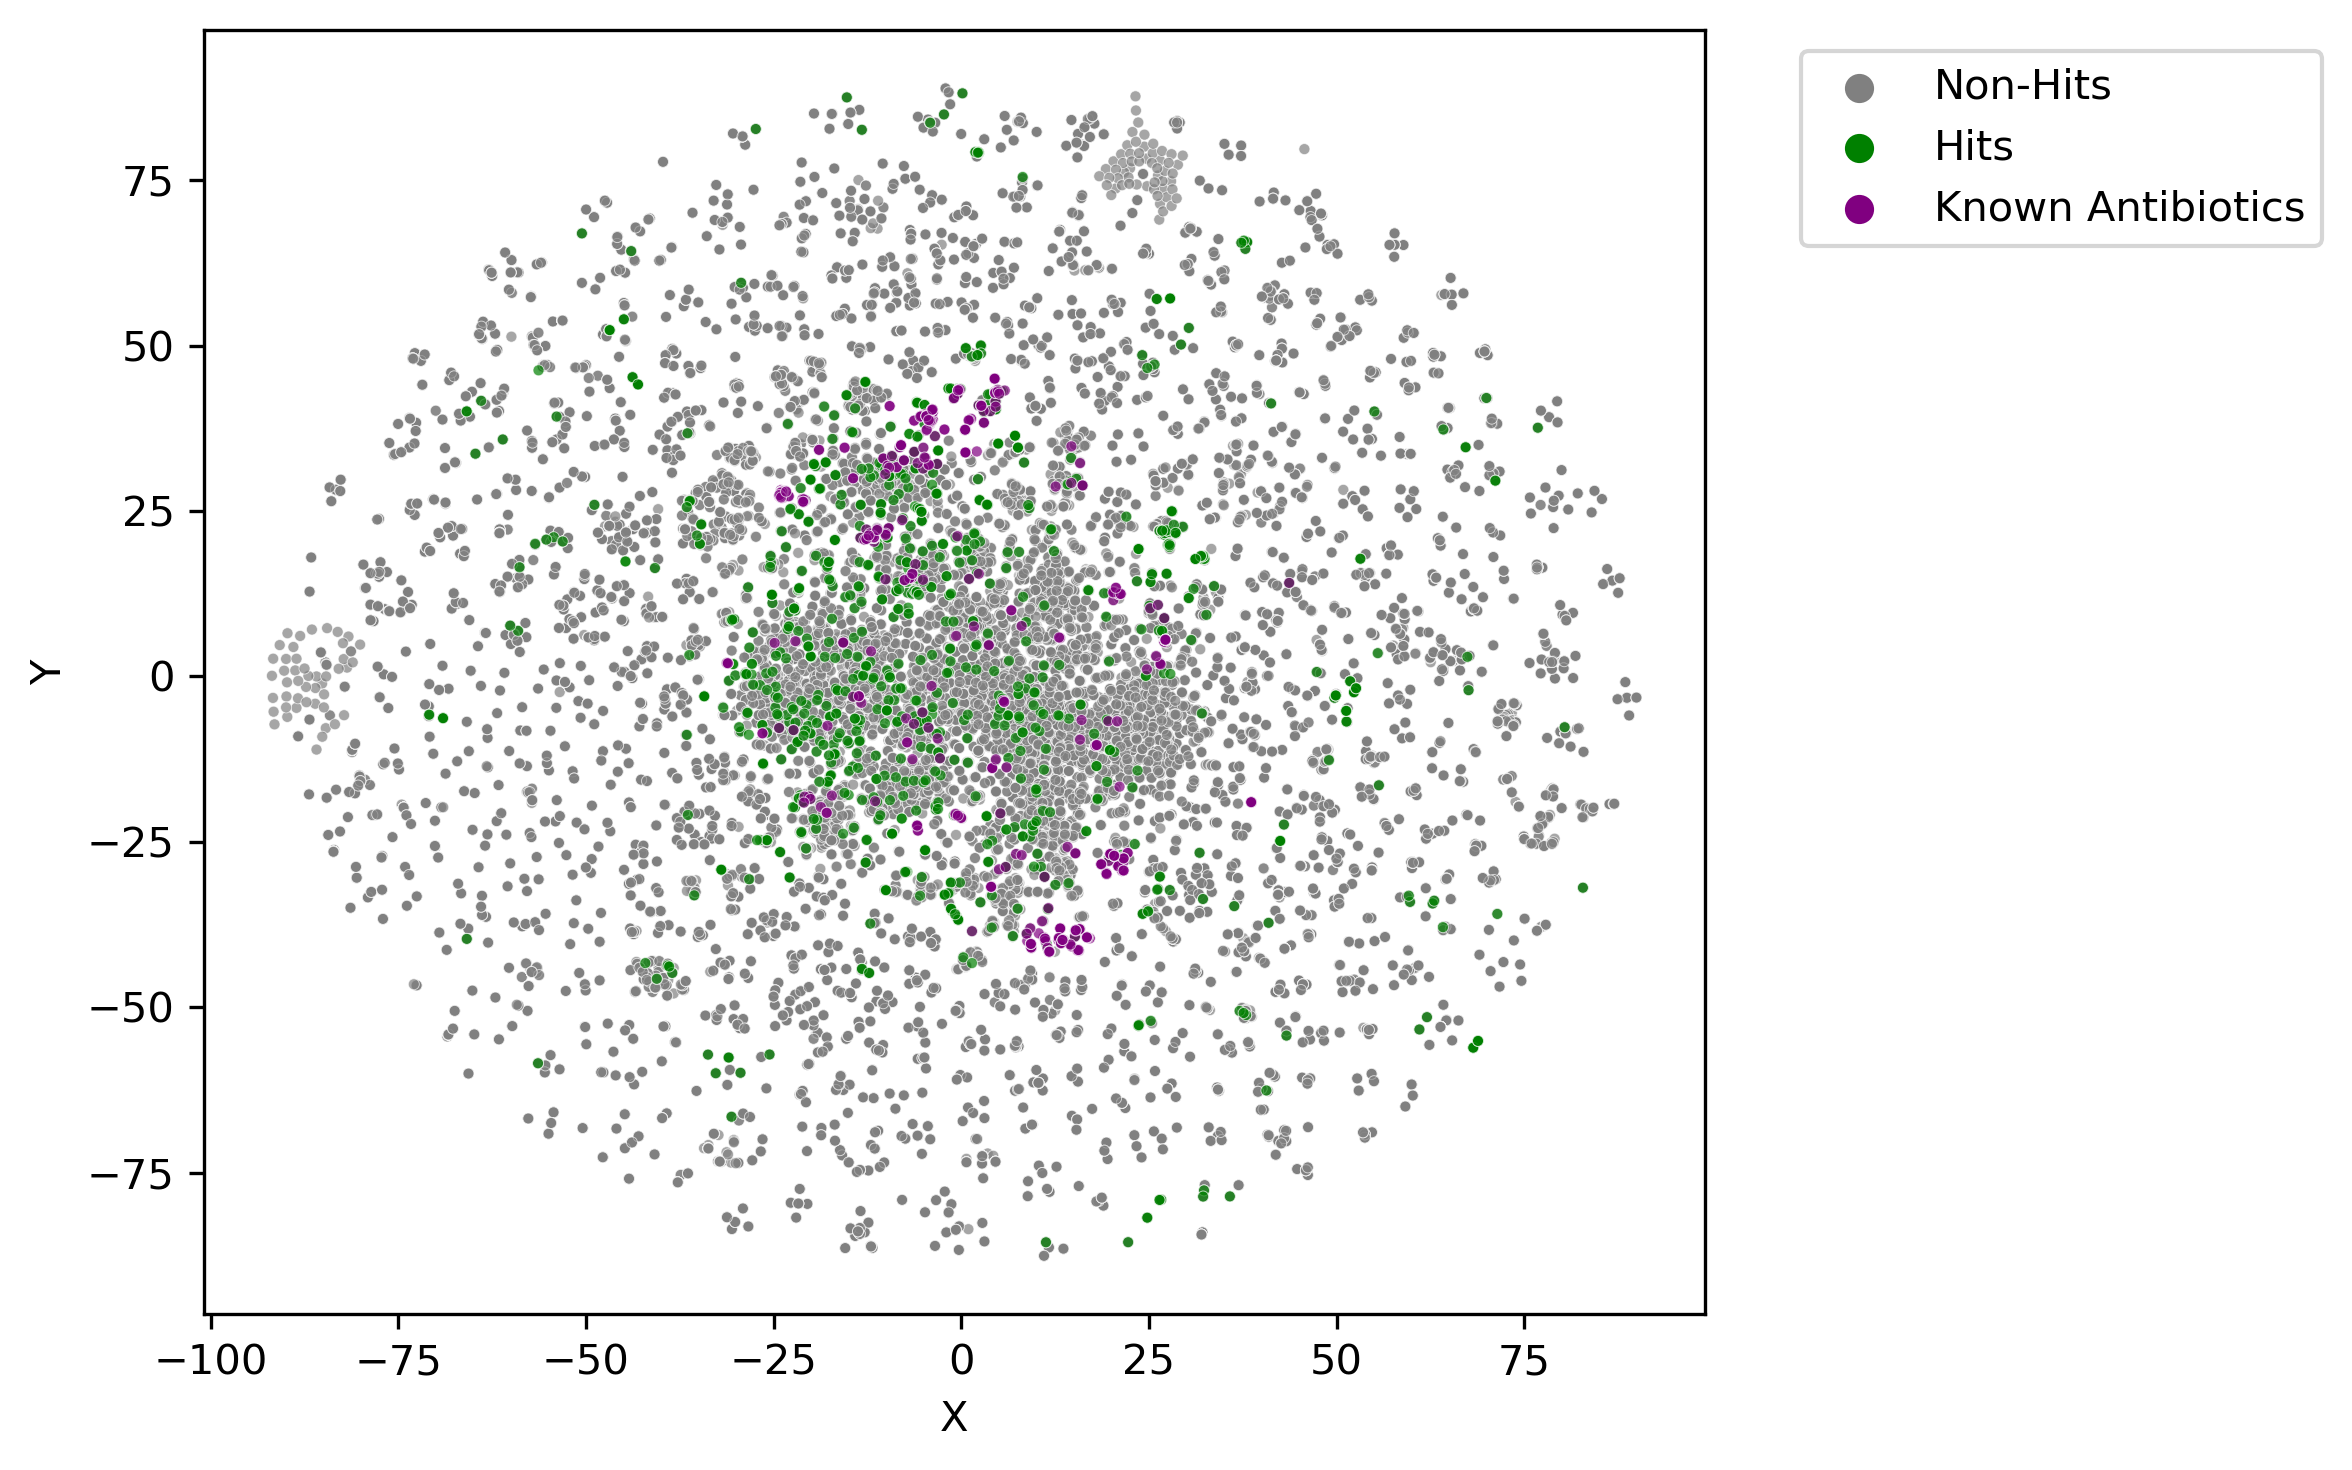

In [19]:
full37kpkhits = full37kpk[full37kpk['hit'] == 1.0]
full37kpknonhits = full37kpk[full37kpk['hit'] == 0.0]

fp_37kpkhits = convert_df_smis_to_fps(full37kpkhits)
fp_37kpknonhits = convert_df_smis_to_fps(full37kpknonhits)

fp_list, fp_labels = make_joined_list_of_fps_and_labels([fp_37kpknonhits, fp_37kpkhits, fp_abx], 
                                                       ['Non-Hits', 'Hits', 'Known Antibiotics'])

tsne_from_pca_components(fp_list, fp_labels, '../figure_panels/tsne_hits_nonhits_abx', colors = ['grey', 'green', 'purple'])

# Quantify diversity

In [ ]:
fp_37k = convert_df_smis_to_fps(full37konly, 'SMILES')
fp_abx = convert_df_smis_to_fps(abx, 'Smiles')
fp_pk = convert_df_smis_to_fps(pkonly, 'SMILES')
fp_37k_pk = fp_37k + fp_pk

full37kpkhits = full37kpk[full37kpk['hit'] == 1.0]
full37kpknonhits = full37kpk[full37kpk['hit'] == 0.0]

fp_37kpkhits = convert_df_smis_to_fps(full37kpkhits)
fp_37kpknonhits = convert_df_smis_to_fps(full37kpknonhits)

In [14]:
print(len(fp_37kpkhits), len(fp_37kpknonhits))

1269 37411


In [12]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
from itertools import combinations

def get_unique_scaffolds(smiles_list):
    """
    Computes the number of unique scaffolds from a list of SMILES strings.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    int: Number of unique scaffolds.
    """
    scaffolds = set()
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffolds.add(Chem.MolToSmiles(scaffold))
    return len(scaffolds)

print('PK number of scaffolds:', get_unique_scaffolds(pkonly['SMILES']))
print('full37konly number of scaffolds:', get_unique_scaffolds(full37konly['SMILES']))
print('PK+37K number of scaffolds: ', get_unique_scaffolds(full37kpk['SMILES']))
print('abx number of scaffolds:', get_unique_scaffolds(abx['Smiles']))
print('PK+37K hits number of scaffolds:', get_unique_scaffolds(full37kpkhits['SMILES']))
print('PK+37K non-hits number of scaffolds:', get_unique_scaffolds(full37kpknonhits['SMILES']))

PK number of scaffolds: 877
full37konly number of scaffolds: 8598
PK+37K number of scaffolds:  9305
abx number of scaffolds: 288
PK+37K hits number of scaffolds: 887
PK+37K non-hits number of scaffolds: 8718


In [ ]:
def average_tanimoto_similarity(fps):
    """
    Computes the average Tanimoto similarity for all pairwise comparisons of a list of fingerprints.

    Parameters:
    fps (list): List of fingerprints.

    Returns:
    float: Average Tanimoto similarity across all pairs.
    """
    total_similarity = 0.0
    num_pairs = 0

    for fp1, fp2 in combinations(fps, 2):
        total_similarity += DataStructs.TanimotoSimilarity(fp1, fp2)
        num_pairs += 1
    
    return total_similarity / num_pairs if num_pairs > 0 else 0.0

print('PK mean tan sim: ', average_tanimoto_similarity(fp_pk))
print('full37konly mean tan sim', average_tanimoto_similarity(fp_37k))
print('PK+37K mean tan sim: ', average_tanimoto_similarity(fp_37k_pk))
print('abx mean tan sim:', average_tanimoto_similarity(fp_abx))
print('PK+37K hits mean tan sim:', average_tanimoto_similarity(fp_37kpkhits))
print('PK+37K non-hits mean tan sim:', average_tanimoto_similarity(fp_37kpknonhits))

In [25]:
def sum_bottleneck(fps):
    """
    Computes the sum of the minimum Tanimoto distances from each molecule to its closest neighbor
    in a list of SMILES strings.

    Normalized by the number of molecules in the list.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    float: Sum of the minimum Tanimoto distances to the closest neighbor for each molecule.
    """    
    # Initialize list to store minimum distances for each molecule
    min_distances = []
    
    # For each fingerprint, compute the minimum "distance" (1 - Tanimoto similarity) to another molecule
    for i, fp1 in enumerate(fps):
        min_distance = float('inf')  # Start with a large number for minimum comparison
        
        # Compare fp1 with every other fingerprint
        for j, fp2 in enumerate(fps):
            if i != j:  # Avoid self-comparison
                similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
                distance = 1 - similarity  # Convert similarity to distance
                min_distance = min(min_distance, distance)  # Update minimum distance if smaller
                
        # Append the minimum distance to the list
        min_distances.append(min_distance)
    
    # Return the sum of all minimum distances
    return sum(min_distances) / len(min_distances)

print('PK sum bottleneck:', sum_bottleneck(fp_pk))
print('full37konly sum bottleneck:', sum_bottleneck(fp_37k))
print('PK+37K sum bottleneck:', sum_bottleneck(fp_37k_pk))
print('abx sum bottleneck:', sum_bottleneck(fp_abx))
print('PK+37K hits sum bottleneck:', sum_bottleneck(fp_37kpkhits))
print('PK+37K non-hits sum bottleneck:', sum_bottleneck(fp_37kpknonhits))

PK sum bottleneck: 0.30786607784137254
full37konly sum bottleneck: 0.060402031800654246
PK+37K sum bottleneck: 0.06424908414993417
abx sum bottleneck: 0.13216816207506826
PK+37K hits sum bottleneck: 0.22243860389868636
PK+37K non-hits sum bottleneck: 0.0619849004078915
